## **Χρήστος-Αλέξανδρος Δαρδαμπούνης ΑΕΜ:10335 (Τμήμα Ηλεκτρολόγων Μηχανικών & Μηχανικών Υπολογιστών)**

# Αναφορά σχετικά με την 3 $^{Η}$ Υποχρεωτική Εργασία

Το παρόν notebook περιλαμβάνει την αναφορά σχετική με την τρίτη υποχρεωτική εργασία όπου φτίαχνω ένα **RBF**(Radial Basis Function) νευρωνικό δίκτυο για να την κατηγοροιοποίηση των εικόνων της CIFAR-10 και συγκρίνω την απόδοση του με την απόδοση που είχαν οι αλγόριθμοι πλησιέστερου γείτονα και πλησιέστερου κέντρου.

Επιπλέον, έγινε και μια προσπάθεια για την δημιουργία ενός autoencoder για την ανακατασκευή των ψηφίων της MNIST που δίνονται στην είσοδο αλλά και για την ανακατασκευή του επόμενου ψηφίου από αυτό που λαμβάνεται στην είσοδο και για την επιβεβαίωση των αποτελεσμάτων χρησιμοποιήθηκε και **MLP** αλλά και **CNN** για να διαπιστώσω πόση καλή μπορεί να θεωρηθεί η ανακατασκευή.

# Εισαγωγή των απαραίτητων βιβλιοθηκών και φόρτωση της βάσης δεδομένων

Αρχικά, κάνω import όλα τα απαραίτητα libraries τα οποία θα χρειαστούν για την σύγκριση των δύο αλγορίθμων οπώς επίσης φορτώνω και την βάση δεδομένων μου σύμφωνα με τις οδηγίες που αναφέρονται στο παρακάτω link : https://www.cs.toronto.edu/~kriz/cifar.html

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import pickle
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from skimage.feature import hog
from sklearn.metrics import silhouette_score, accuracy_score
from collections import defaultdict # Import defaultdict to create a dictionary with default values

Οι παραπάνω βιβλιοθήκες είναι χρήσιμες για τους εξής λόγους :
* Η **numpy** για πράξεις μεταξύ πινάκων και διανυσμάτων, για αποφυγή for loops και για κατάλληλο χειρισμό των εικόνων.
* Η **matplolib** για την οπτικοποίηση των αποτελεσμάτων μας. 
* Η **opencv(cv2)** για τον διαχειρισμό των εικόνων της CIFAR-10.
* Η **PyTorch(torch)** για την δημιουργία του νευρωνικού δικτύου και για την εκπαίδευση τους στην κάρτα γραφικών **(GPU)** για μεγαλύτερες ταχύτητες εκτέλεσης.
* Η **os** και η **pickle** για την φόρτωση των αρχείων της CIFAR-10.
* Επίσης από την **sklearn** κάνω import την κλάση `StandardScaler()` και την κλάση `PCA()` για να μειώσω τις διαστάσεις του προβλήματος μου και να βοηθήσω τους αλγόριθμους.
* Εισάγω επίσης από την **sklearn.cluster** την `KMeans()` για να πραγματοποιήσω το αλγόριθμο **Κ-Means** μέσω του οποίου θα κάνω προσδιορισμό των κέντρων των **RBF** πυρήνων που θα χρησιμοποιηθούν στο **RBF** νευρωνικό μου δίκτυο.
* Εισάγω επίσης την **seaborn** μέσω της οποίας θα κάνω κάποια επιπλέον plots όπως το `silhouette_score()`(το οποίο το εισάγω από την **sklearn.metrics**) μέσω του οποίου θα μπορέσω να προσδιορίσω τον ιδανικό αριθμό των κέντρων που μου δίνει το καλύτερο αποτέλεσμα στον διαχωρισμό των κλάσεων.
* Επιπλέον, εισάγω από την **skimage** την συνάρτηση `hog()` ο οποίος είναι ένας feature descriptor αλγόριθμος που μετράει τις εμφανίσεις των προσανατολισμών των gradient σε τοπικές μερίδες της εικόνας, δίνοντας έτσι χρήσιμα χαρακτηριστικά τα οποία μπορούν να χρησιμοποιηθούν αντί για ολόκληρο το set των features και άρα μπορεί να βοηθήσει στην κατηγοριοποίση των εικόνων ενώ επίσης μπορεί να επιταγχύνει σημαντικά την διαδικασία εκπαίδευσης.
* Επιπρόσθετα, από την `torch` εισάγω το module `nn` το οποίο παρέχει απαραίτητες συναρτήσεις που θα με βοηθήσουν να στήσω το νευρωνικό (είτε **MLP** είτε **CNN**).

## Φόρτωση της CIFAR-10 

Στο παρακάτω κομμάτι κώδικα φορτώνω όλα τα αρχεία της βάσης και τα χωρίζω σε training και testing, όπως επίσης χωρίζω και τα labels.

In [3]:
directory = r'C:\Users\chris\OneDrive\Υπολογιστής\9ο ΕΞΑΜΗΝΟ\ΝΕΥΡΩΝΙΚΑ ΔΙΚΤΥΑ & ΒΑΘΙΑ ΜΑΘΗΣΗ\cifar-10-python\cifar-10-batches-py'
data = {}
for file in os.listdir(directory):
    with open(directory + "\\" + file, 'rb') as f:
        data[f'{file}'] =  pickle.load(f, encoding='bytes')

filename = r'C:\Users\chris\OneDrive\Υπολογιστής\9ο ΕΞΑΜΗΝΟ\ΝΕΥΡΩΝΙΚΑ ΔΙΚΤΥΑ & ΒΑΘΙΑ ΜΑΘΗΣΗ\cifar-10-python\cifar-10-batches-py\test_batch'
with open(filename, 'rb') as fo:
    test_data = pickle.load(fo, encoding='bytes')


X_train = np.vstack((data['data_batch_1'][b'data'], data['data_batch_2'][b'data'], data['data_batch_3'][b'data'], data['data_batch_4'][b'data'], data['data_batch_5'][b'data']), dtype=np.uint8)
y_train = np.hstack((data['data_batch_1'][b'labels'], data['data_batch_2'][b'labels'], data['data_batch_3'][b'labels'], data['data_batch_4'][b'labels'], data['data_batch_5'][b'labels']), dtype=np.int32)
X_test = test_data[b'data']
y_test = np.array(test_data[b'labels'])
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 3072), (50000,), (10000, 3072), (10000,))

In [4]:
filename = r'C:\Users\chris\OneDrive\Υπολογιστής\9ο ΕΞΑΜΗΝΟ\ΝΕΥΡΩΝΙΚΑ ΔΙΚΤΥΑ & ΒΑΘΙΑ ΜΑΘΗΣΗ\cifar-10-python\batches.meta'
with open(filename, 'rb') as fo:
    example = pickle.load(fo, encoding='bytes')

label_names = [label_name.decode('utf-8') for label_name in example[b'label_names']] 
label_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

## Image Visualization

Στην συνέχεια για να βεβαιωθώ όταν φορτώθηκαν σωστά τα αρχεία από την CIFAR-10 σχηματίζω τις εικόνες και κάνω plot ενδεικτικά μια από αυτές.

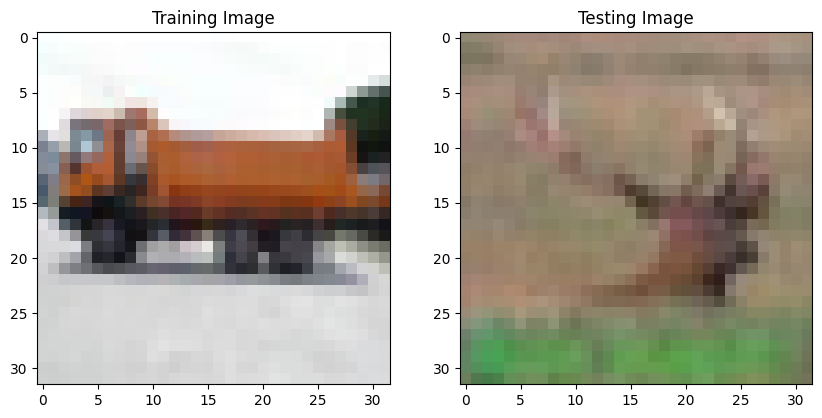

In [5]:
X = np.vstack((X_train, X_test))
img = np.zeros(shape=(32, 32, 3), dtype=np.uint8)
images = np.zeros(shape=(X.shape[0], 32, 32, 3), dtype=np.uint8)
train_images = np.zeros(shape=(X_train.shape[0], 32, 32, 3), dtype=np.uint8)
test_images = np.zeros(shape=(X_test.shape[0], 32, 32, 3), dtype=np.uint8)

for i in range(X.shape[0]):
    red_channel   = X[i, 0:1024].reshape(32, 32)
    green_channel = X[i, 1024:2048].reshape(32, 32)
    blue_channel  = X[i, 2048:3072].reshape(32, 32)

    img = np.dstack((red_channel, green_channel, blue_channel))

    images[i] = img

for i in range(X_train.shape[0]):
    red_channel   = X_train[i, 0:1024].reshape(32, 32)
    green_channel = X_train[i, 1024:2048].reshape(32, 32)
    blue_channel  = X_train[i, 2048:3072].reshape(32, 32)

    img = np.dstack((red_channel, green_channel, blue_channel))

    train_images[i] = img

for i in range(0, X_test.shape[0]):
    red_channel   = X_test[i, 0:1024].reshape(32, 32)
    green_channel = X_test[i, 1024:2048].reshape(32, 32)
    blue_channel  = X_test[i, 2048:3072].reshape(32, 32)

    img = np.dstack((red_channel, green_channel, blue_channel))
    test_images[i] = img

fig, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].imshow(train_images[28635])
ax[0].set_title('Training Image')
ax[1].imshow(test_images[2183])
ax[1].set_title('Testing Image')
plt.show()

## ΗΟG Features

Στην ενδιάμεση εργασία είχα καταλήξει στο γεγονός πως τα features που εξήγαγα από την κάθε εικόνα μου έδιναν τα καλύτερα αποτέλεσμα και για τον αλγόριθμο πλησιέστερου γείτονα αλλά και για τον αλγόριθμου πλησιέστερου κέντρου, οπότε για αυτό τον λόγο θεωρώ λογικό να φτιάξω αρχικά ένα νευρωνικό προσαρμοσμένο σε αυτά καθότι αναμένω πως και αυτό θα μου δώσει αρκετά καλά αποτελέσματα. Οπότε, όπως και προηγουμένως κάνω εξαγωγή αυτών των features και στην συνέχεια δημιουργώ την κλάση για το νευρωνικό. 

In [5]:
def compute_hog_features(image):
    hog_features, hog_image = hog(image, pixels_per_cell=(8, 8),
                                  cells_per_block=(2, 2), visualize=True, channel_axis=-1, transform_sqrt=True)
    return hog_features

X_train_HOG = np.zeros(shape=(train_images.shape[0], 324))
X_test_HOG  = np.zeros(shape=(test_images.shape[0], 324))

for i in range(train_images.shape[0]):
    X_train_HOG[i, :] = compute_hog_features(train_images[i])

for i in range(test_images.shape[0]):
    X_test_HOG[i, :] = compute_hog_features(test_images[i])

X_train_HOG.shape, X_test_HOG.shape

((50000, 324), (10000, 324))

# **RBF Neural Network**

To RBF νευρωνικό δίκτυο μεταφέρει τις εισόδους στους κρυφούς νευρώνες οι οποίοι χρησιμοποιούν συναρτήσεις ακτινικής βάσης και πιο συγκεκριμένα χρησιμοποιούν την Gaussian συνάρτηση:
$$
\phi(x) = \exp\left(-\frac{\|x-c_i\|^2}{2\sigma^2}\right)
$$
Όπου x είναι το διάνυσμα εισόδου, $ c_i $ είναι το κέντρου του $ i-στου $ RBF νευρώνα και $ \sigma $ είναι η τυπική απόκλιση.
Τέλος, η έξοδος του δικτύου δίνεται από την εξής εξίσωση: $ y(x) = \sum_{i=1}^N w_i \cdot \phi(x) $

Παρακάτω φαίνεται μια πρώτη υλοποίηση της κλάσης στην οποία φτιάχνω το RBF. Αρχικά όπως βλέπουμε επιλέγω οι μέσες τιμές να είναι τα κέντρα των clusters που έχουν προσδιοριστεί από τον αλγόριθμο **K-Means** ενώ επιλέγω η τυπική απόκλιση να είναι ίση με 
$$
\sigma = \frac{d_{\text{max}}}{\sqrt{2K}}
$$
το οποίο θεωρείται μια καλή αρχική επιλογή.

In [16]:
class RBF_NN(nn.Module):

  def __init__(self, clusters:np.array, output_size:int):
    super().__init__()
    self.num_kernels = clusters.shape[0]
    self.means = nn.Parameter(torch.from_numpy(clusters).float(), requires_grad=True)
    distances = torch.cdist(self.means, self.means, p=2)
    distances.fill_diagonal_(float('-inf'))
    # print(self.means.shape)
    # print(distances)
    # print(torch.max(distances))
    # print(torch.tensor(np.sqrt(2*self.num_kernels)))

    sigma = torch.max(distances) / (torch.sqrt(torch.tensor(2*self.num_kernels, dtype=torch.float32)))
    self.sigmas = nn.Parameter(torch.ones(self.num_kernels, dtype=torch.float32) * sigma, requires_grad=True)
    self.batch = nn.BatchNorm1d(self.means.shape[1])
    self.output_layer = nn.Linear(in_features=self.num_kernels, out_features=output_size)
   


  def forward(self, x):
    diff = x.unsqueeze(1) - self.means
    distances = torch.sum(diff**2, dim=2)
    # x = self.batch(x)
    # distances = torch.cdist(x, self.means, p=2) ** 2
    RBF = torch.exp(-0.5*(distances) / (self.sigmas**2))
    return self.output_layer(RBF)

In [30]:
class RBF_NN2(nn.Module):

  def __init__(self, clusters:np.array, output_size:int):
    super().__init__()
    self.num_kernels = clusters.shape[0]
    self.means = nn.Parameter(torch.from_numpy(clusters).float(), requires_grad=True)
    distances = torch.cdist(self.means, self.means, p=2)
    distances.fill_diagonal_(float('-inf'))
    # print(self.means.shape)
    # print(distances)
    # print(torch.max(distances))
    # print(torch.tensor(np.sqrt(2*self.num_kernels)))

    sigma = torch.max(distances) / (torch.sqrt(torch.tensor(2*self.num_kernels, dtype=torch.float32)))
    self.sigmas = nn.Parameter(torch.ones(self.num_kernels, dtype=torch.float32) * sigma, requires_grad=True)
    self.batch = nn.BatchNorm1d(self.means.shape[1])
    self.output_layer = nn.Linear(in_features=self.num_kernels, out_features=output_size)
   


  def forward(self, x):
    # diff = x.unsqueeze(1) - self.means
    # distances = torch.sum(diff**2, dim=2)
    # x = self.batch(x)
    distances = torch.cdist(x, self.means, p=2) ** 2
    RBF = torch.exp(-0.5*(distances) / (self.sigmas**2))
    return self.output_layer(RBF)

Επιπλέον, όπως και στις προηγουμένες εργασίες υλοποιώ και εδώ πέρα μια συνάρτηση μέσω της οποίας υπολογίζω την ακρίβεια που καταφέρνει να πίασει η υλοποίηση του νευρωνικού μου καθώς επίσης και μια συνάρτηση μέσως της οποίας πλοτάρω τα αποτελέσματα για να παρουσιάσω την πορεία της εκπαίδευσης.

In [7]:
def accuracy(y_test, y_preds):
  count = torch.eq(y_test, y_preds).sum().item()
  acc = count / len(y_test) * 100
  return acc

def plot_loss_acc_curves(epoch_count, loss_values, test_loss_values, acc_values, test_acc_values):
    plt.figure(figsize=(12, 8))

    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212)
    ax1.plot(epoch_count, loss_values, label='Train Loss', color='blue')
    ax1.plot(epoch_count, test_loss_values, label='Test Loss', color='red')
    ax1.set_title("Training & Testing Loss Curves")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.grid(True)


    ax2.plot(epoch_count, acc_values, label='Train Accuracy', color='blue')
    ax2.plot(epoch_count, test_acc_values, label='Test Accuracy', color='red')
    ax2.set_title("Training & Testing Accuracy Curves")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Στην συνέχεια χρησιμοποιώ τον αλγόριθμο `K-Means` για τον προσδιορισμό των clusters και κατά επέκταση των κέντρων των clusters τα οποία θα τα χρησιμοποιήσω ως τις μέσες τιμές των RBF πυρήνων των νευρώνων του κρυφού επιπέδου του νευρωνικού δικτύου.

In [9]:
k_model = KMeans(n_clusters=10, n_init=10)
k_model.fit(X_train)

KMeans(n_clusters=10, n_init=10)

In [10]:
cluster_centers = k_model.cluster_centers_
cluster_centers.shape[0]

10

In [11]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [17]:
X_train_tensor = torch.from_numpy(X_train).to(device).type(torch.float32)
X_test_tensor = torch.from_numpy(X_test).to(device).type(torch.float32)
y_train_tensor = torch.from_numpy(y_train).to(device).type(torch.long)
y_test_tensor = torch.from_numpy(y_test).to(device).type(torch.long)

In [13]:
X_train_tensor = torch.from_numpy(X_train_sc).to(device).type(torch.float32)
X_test_tensor = torch.from_numpy(X_test_sc).to(device).type(torch.float32)

In [18]:
X_train_HOG_tensor = torch.from_numpy(X_train_HOG).to(device).type(torch.float32)
X_test_HOG_tensor  = torch.from_numpy(X_test_HOG).to(device).type(torch.float32)

In [22]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
RBF_model = RBF_NN(clusters=cluster_centers, output_size=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(RBF_model.parameters(), lr=0.1)

torch.manual_seed(42)
torch.cuda.manual_seed(42)  

epochs = 100
epoch_count = []
loss_values = []
test_loss_values = []
acc_values = []
test_acc_values = []

for epoch in range(epochs):
    RBF_model.train()
    train_loss = 0
    train_acc = 0
    for X_batch, y_batch in train_loader:
        y_pred = RBF_model(X_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += accuracy(y_batch, torch.argmax(y_pred, dim=1))
    
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    loss_values.append(train_loss)
    acc_values.append(train_acc)
    
    test_loss = 0
    test_acc = 0
    RBF_model.eval()
    with torch.inference_mode():
        for X_batch, y_batch in test_loader:
            y_pred = RBF_model(X_batch)
            loss = criterion(y_pred, y_batch)
            test_loss += loss.item()
            test_acc += accuracy(y_batch, torch.argmax(y_pred, dim=1))
    
    test_loss /= len(test_loader)
    test_acc /= len(test_loader)
    test_loss_values.append(test_loss)
    test_acc_values.append(test_acc)
    
    epoch_count.append(epoch)
    print(f'Epoch {epoch+1}/{epochs} Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}% Test Loss: {test_loss:.4f} Test Acc: {test_acc:.2f}%')

Epoch 1/100 Train Loss: 1.9618 Train Acc: 27.68% Test Loss: 1.9131 Test Acc: 29.85%
Epoch 2/100 Train Loss: 1.8774 Train Acc: 31.00% Test Loss: 1.8608 Test Acc: 32.18%
Epoch 3/100 Train Loss: 1.8427 Train Acc: 32.39% Test Loss: 1.8326 Test Acc: 33.41%
Epoch 4/100 Train Loss: 1.8167 Train Acc: 33.80% Test Loss: 1.8000 Test Acc: 34.53%
Epoch 5/100 Train Loss: 1.7989 Train Acc: 34.57% Test Loss: 1.7899 Test Acc: 35.12%
Epoch 6/100 Train Loss: 1.7805 Train Acc: 35.27% Test Loss: 1.7657 Test Acc: 36.40%
Epoch 7/100 Train Loss: 1.7664 Train Acc: 35.88% Test Loss: 1.7640 Test Acc: 37.08%
Epoch 8/100 Train Loss: 1.7549 Train Acc: 36.67% Test Loss: 1.7432 Test Acc: 37.52%
Epoch 9/100 Train Loss: 1.7437 Train Acc: 37.03% Test Loss: 1.7381 Test Acc: 37.76%
Epoch 10/100 Train Loss: 1.7360 Train Acc: 37.18% Test Loss: 1.7263 Test Acc: 38.34%
Epoch 11/100 Train Loss: 1.7307 Train Acc: 37.49% Test Loss: 1.7303 Test Acc: 37.80%
Epoch 12/100 Train Loss: 1.7238 Train Acc: 37.79% Test Loss: 1.7333 Test A

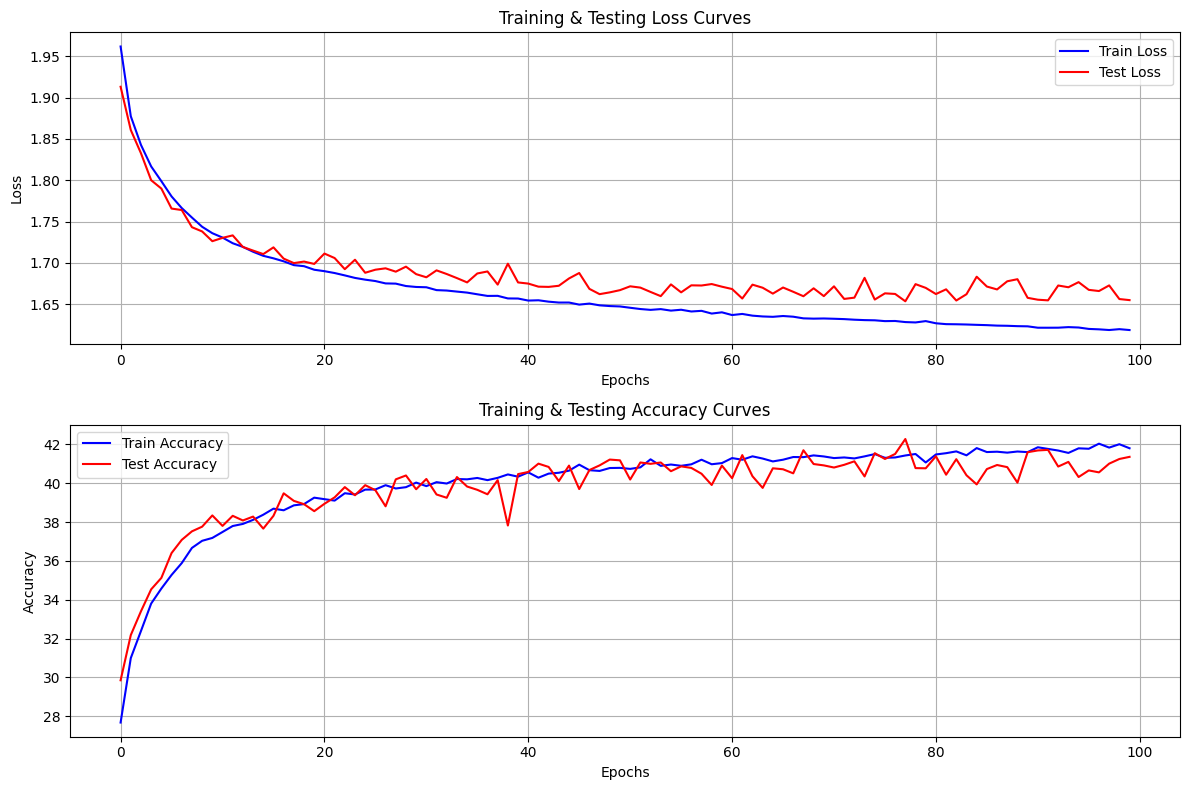

In [25]:
plot_loss_acc_curves(epoch_count, loss_values, test_loss_values, acc_values, test_acc_values)

Όπως μπορούμε να παρατηρήσουμε τα αποτελέσματα που λαμβάνουμε από το παραπάνω **RBF** νευρωνικό δίκτυο δεν είναι τόσο καλά όσο αυτά που παίρναμε από τους αλγοριθμούς πλησιέστερου γείτονα και πλησιέστερου κέντρου. Αυτό το γεγονός, μας δείχνει πως το νευρωνικό δεν είναι σε θέση να μπορέσει να πραγματοποιήσει σωστή κατηγοριοποίηση των δειγμάτων της CIFAR-10, μιας βιβλιοθήκης που είναι αρκετά απαιτητική και διαθέτει πολλά features. Ας δοκιμάσουμε ωστόσο να δούμε και την απόδοση του όταν βάζουμε μεγαλύτερο αριθμό κέντρων και άρα δηλαδή περισσότερους **RBF** kernels στο κρυφό επίπεδο για να εξάγουμε καλύτερα τα χαρακτηριστικά των εικόνων.

In [26]:
kmeans = KMeans(n_clusters=100, n_init=10)
kmeans.fit(X_train)
cluster_centers_100 = kmeans.cluster_centers_

In [31]:
RBF_model = RBF_NN2(cluster_centers_100, 10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(RBF_model.parameters(), lr=0.75, weight_decay=1e-4)
optimizer = torch.optim.SGD(RBF_model.parameters(), lr=0.1, momentum=0.8)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 5001
epoch_count = []
loss_values = []
test_loss_values = []
acc_values = []
test_acc_values = []

for epoch in range(epochs):
  RBF_model.train()

  y_logits = RBF_model(X_train_tensor)
  y_pred_probs = torch.softmax(y_logits, dim=1)
  y_preds = torch.argmax(y_pred_probs, dim=1)

  loss = loss_fn(y_logits, y_train_tensor)
  train_acc = accuracy(y_train_tensor, y_preds)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  RBF_model.eval()
  with torch.inference_mode():
    y_test_logits = RBF_model(X_test_tensor)
    y_test_pred_probs = torch.softmax(y_test_logits, dim=1)
    y_test_preds = torch.argmax(y_test_pred_probs, dim=1)

    test_loss = loss_fn(y_test_logits, y_test_tensor)
    test_acc  = accuracy(y_test_tensor, y_test_preds)

  if epoch % 10 == 0 :
    epoch_count.append(epoch)
    loss_values.append(loss.item())
    test_loss_values.append(test_loss.item())
    acc_values.append(train_acc)
    test_acc_values.append(test_acc)
    print(f"Epoch {epoch} | Loss : {loss:.5f} | Accuracy : {train_acc:.2f}% | Test Loss : {test_loss:.5f} | Test Accuracy : {test_acc:.2f}%")

Epoch 0 | Loss : 2.30290 | Accuracy : 9.99% | Test Loss : 2.30281 | Test Accuracy : 10.00%
Epoch 10 | Loss : 2.30259 | Accuracy : 9.97% | Test Loss : 2.30249 | Test Accuracy : 10.00%
Epoch 20 | Loss : 2.30236 | Accuracy : 9.95% | Test Loss : 2.30227 | Test Accuracy : 10.07%
Epoch 30 | Loss : 2.30225 | Accuracy : 9.99% | Test Loss : 2.30217 | Test Accuracy : 10.02%
Epoch 40 | Loss : 2.30218 | Accuracy : 9.78% | Test Loss : 2.30210 | Test Accuracy : 9.98%
Epoch 50 | Loss : 2.30212 | Accuracy : 11.87% | Test Loss : 2.30205 | Test Accuracy : 12.08%
Epoch 60 | Loss : 2.30206 | Accuracy : 12.16% | Test Loss : 2.30199 | Test Accuracy : 12.29%
Epoch 70 | Loss : 2.30201 | Accuracy : 12.41% | Test Loss : 2.30193 | Test Accuracy : 12.66%
Epoch 80 | Loss : 2.30195 | Accuracy : 12.51% | Test Loss : 2.30188 | Test Accuracy : 12.63%
Epoch 90 | Loss : 2.30190 | Accuracy : 12.68% | Test Loss : 2.30182 | Test Accuracy : 12.87%
Epoch 100 | Loss : 2.30185 | Accuracy : 12.81% | Test Loss : 2.30177 | Test A

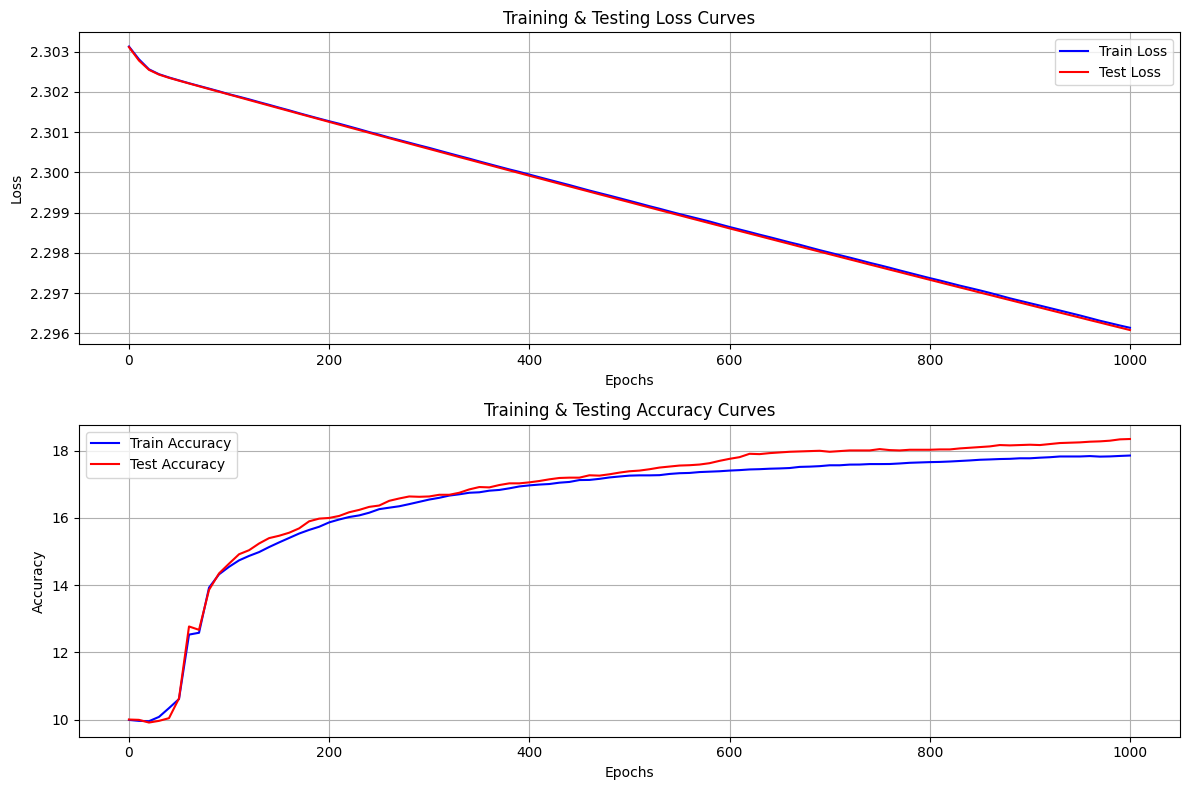

In [45]:
plot_loss_acc_curves(epoch_count, loss_values, test_loss_values, acc_values, test_acc_values)

Όπως μπορούμε να παρατηρήσουμε από τα παρακάτω διαγράμματα καθώς επίσης και από τα αποτελέσματα βλέπουμε πως με την εισαγωγή περισσότερων κέντρων παίρνουμε χειρότερα αποτελέσματα σε σχέση με προηγουμένως, επομένως μάλλον είναι καλύτερα να χρησιμοποιούμε λιγότερους RBF πυρήνες για το νευρωνικό μας. Αυτό μπορούμε να το διαπιστώσουμε και από τα παρακάτω γραφήματα.

In [15]:
K = [2, 5, 10, 15, 20, 50, 100]

fits = []
distortions = []
scores = []

for k in K:
  print(k)
  kmeans = KMeans(n_clusters=k, random_state=0).fit(X_train)
  score = silhouette_score(X_train, kmeans.labels_)
  scores.append(score)

  distortions.append(kmeans.inertia_)
  fits.append(kmeans)

2
5
10
15
20
50
100


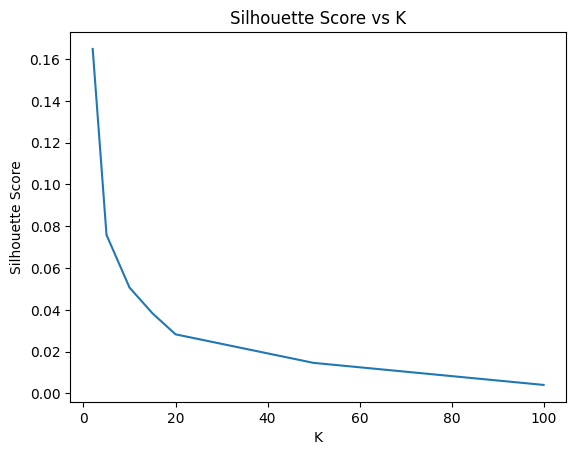

In [16]:
sns.lineplot(x=K, y=scores)
plt.title("Silhouette Score vs K")
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.show()

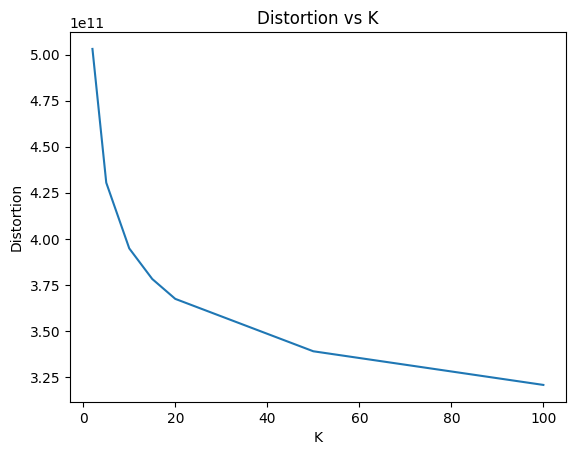

In [17]:
sns.lineplot(x=K, y=distortions)
plt.title("Distortion vs K")
plt.xlabel("K")
plt.ylabel("Distortion")
plt.show()

Από τα παραπάνω γραφήματα παρατηρούμε πως όσο μικρότερο είναι το πλήθος των κέντρων τόσο μεγαλύτερο είναι το `silhouette score` και άρα τόσο καλύτερα γίνεται ο προσδιορισμός των clusters και κατά επέκταση και η κατηγοριοποίηση των δειγμάτων στις κατάλληλες κλάσεις με την χρήση του **RBF** νευρωνικού δικτύου. Ωστόσο, όπως μπορούμε να παρατηρήσουμε το νευρωνικό εξακολουθεί να δυσκολεύεται να κατηγοριοποιήσει ορθά τα δείγματα στις κατάλληλες κλάσεις λόγω του πολύ μεγάλου πλήθους των features, ενώ ακόμα παρατήρησα πως είναι αρκετά ευαίσθητο σε όποιες αλλαγές γίνονται στις υπερπαραμέτρους. Ας δοκιμάσουμε να δούμε τι απόδοση θα έχει το νευρωνικό όταν χρησιμοποιηθούν τα HOG features.

In [20]:
kmeans_hog = KMeans(n_clusters=10, n_init=10).fit(X_train_HOG)
cluster_centers_hog = kmeans_hog.cluster_centers_

In [29]:
RBF_model = RBF_NN2(cluster_centers_hog, 10).to(device)
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(RBF_model.parameters(), lr=0.5, weight_decay=1e-4)
optimizer = torch.optim.SGD(RBF_model.parameters(), lr=0.1, momentum=0.8)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 50001
epoch_count = []
loss_values = []
test_loss_values = []
acc_values = []
test_acc_values = []

for epoch in range(epochs):
  RBF_model.train()

  y_logits = RBF_model(X_train_HOG_tensor)
  y_pred_probs = torch.softmax(y_logits, dim=1)
  y_preds = torch.argmax(y_pred_probs, dim=1)

  loss = loss_fn(y_logits, y_train_tensor)
  train_acc = accuracy(y_train_tensor, y_preds)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  RBF_model.eval()
  with torch.inference_mode():
    y_test_logits = RBF_model(X_test_HOG_tensor)
    y_test_pred_probs = torch.softmax(y_test_logits, dim=1)
    y_test_preds = torch.argmax(y_test_pred_probs, dim=1)

    test_loss = loss_fn(y_test_logits, y_test_tensor)
    test_acc  = accuracy(y_test_tensor, y_test_preds)

  if epoch % 10 == 0 :
    epoch_count.append(epoch)
    loss_values.append(loss.item())
    test_loss_values.append(test_loss.item())
    acc_values.append(train_acc)
    test_acc_values.append(test_acc)
    print(f"Epoch {epoch} | Loss : {loss:.5f} | Accuracy : {train_acc:.2f}% | Test Loss : {test_loss:.5f} | Test Accuracy : {test_acc:.2f}%")

Epoch 0 | Loss : 2.30949 | Accuracy : 10.00% | Test Loss : 2.30934 | Test Accuracy : 10.00%
Epoch 10 | Loss : 2.30585 | Accuracy : 10.00% | Test Loss : 2.30549 | Test Accuracy : 10.00%
Epoch 20 | Loss : 2.30347 | Accuracy : 10.00% | Test Loss : 2.30334 | Test Accuracy : 10.00%
Epoch 30 | Loss : 2.30275 | Accuracy : 10.01% | Test Loss : 2.30271 | Test Accuracy : 10.01%
Epoch 40 | Loss : 2.30256 | Accuracy : 10.17% | Test Loss : 2.30255 | Test Accuracy : 10.21%
Epoch 50 | Loss : 2.30250 | Accuracy : 10.88% | Test Loss : 2.30249 | Test Accuracy : 11.01%
Epoch 60 | Loss : 2.30247 | Accuracy : 11.97% | Test Loss : 2.30246 | Test Accuracy : 12.06%
Epoch 70 | Loss : 2.30244 | Accuracy : 15.66% | Test Loss : 2.30243 | Test Accuracy : 15.50%
Epoch 80 | Loss : 2.30241 | Accuracy : 14.66% | Test Loss : 2.30239 | Test Accuracy : 14.32%
Epoch 90 | Loss : 2.30237 | Accuracy : 12.63% | Test Loss : 2.30234 | Test Accuracy : 12.41%
Epoch 100 | Loss : 2.30231 | Accuracy : 12.62% | Test Loss : 2.30228 | 

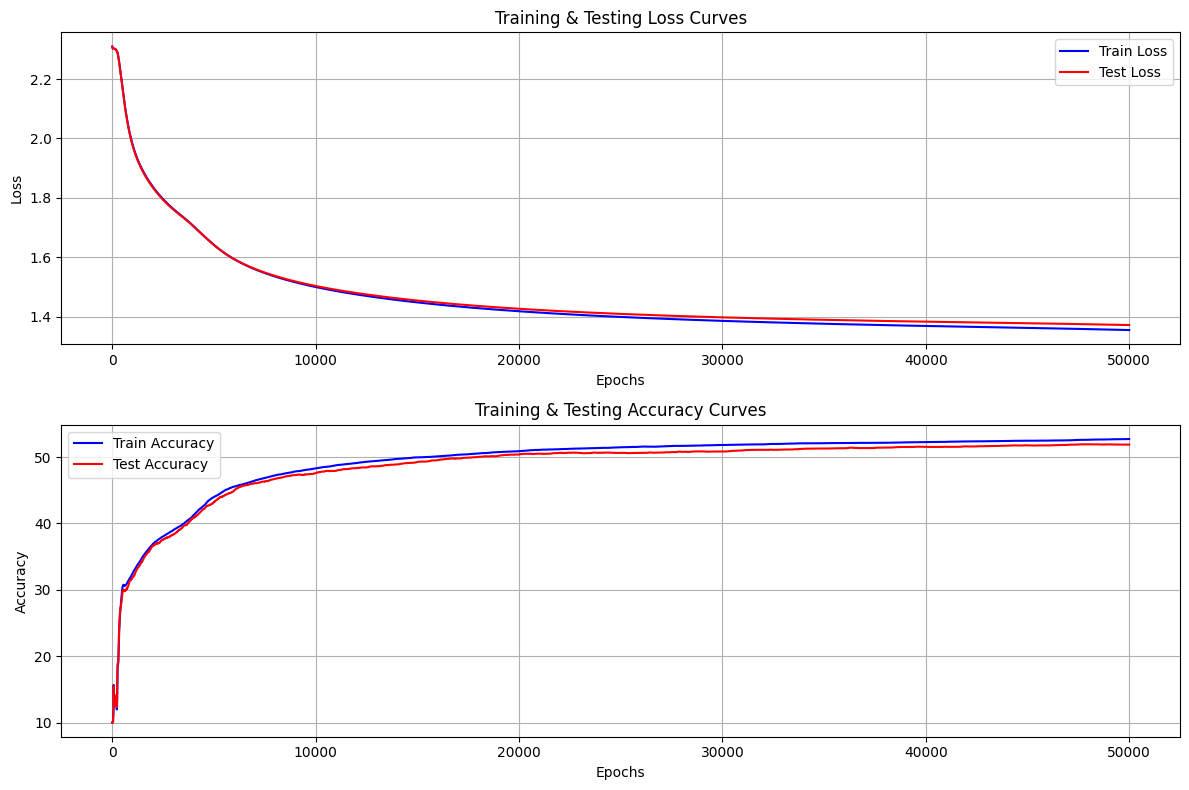

In [30]:
plot_loss_acc_curves(epoch_count, loss_values, test_loss_values, acc_values, test_acc_values)

Όπως μπορούμε να παρατηρήσουμε τα HOG features έχουν αποδώσει πολύ καλύτερα από ότι τα raw δεδομένα της CIFAR-10 ενώ ακόμα παρατηρώ πως όταν τρέχει για περισσότερα epochs βελτιώνεται ακόμα περισσότερο. Ο βασικότερος λόγος για τον οποίο αποδίδουν πολύ καλύτερα είναι διότι μειώνουν σε σημαντικό βαθμό την διάσταση του προβλήματος κρατώντας όμως την πιο σημαντική πληροφορία της κάθε εικόνας με αποτέλεσμα να γίνεται και πιο εύκολα ο προσδιορισμός των κέντρων των clusters από τον `K-means` αλλά γίνεται επίσης και πιο ορθά η κατηγοριοποίηση των δειγμάτων από το RBF δίκτυο που έχω φτιάξει. Βλέπουμε και εδώ δηλαδή ότι για τα συγκεκριμένα δεδομένα η εξαγωγή των HOG features μας βοηθάει σε πολύ σημαντικό βαθμό στην ταξινόμηση όπως ακριβώς μας βοηθούσε και στους αλγορίθμους πλησιέστερου γείτονα, πλησιέστερου κέντρου αλλά και στο **SVM** και στα νευρωνικά δίκτυα που έφτιαξα στις προηγούμενες εργασίες.

# **Εφαρμογή PCA στα raw δεδομένα**

Βλέπουμε λοιπόν πως με την μείσωη της διάστασης μέσω των HOG features κατορθώσαμε να επιτύχουμε ένα πολύ καλό ποσοστό ακρίβειας ταξινόμησης των κλάσεων. Ας δοκιμάσουμε τώρα να εφαρμόσουμε `PCA` στα δεδομένα μας για να μειώσουμε την διάστασή τους και να δούμε πως θα αποδόσει το **RBF** νευρωνικό μας δίκτυο και σε αυτή την περίπτωση.

In [31]:
pca = PCA(n_components=50)
scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)
X_train_pca = pca.fit_transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)

In [32]:
X_train_pca_tensor = torch.from_numpy(X_train_pca).to(device).type(torch.float32)
X_test_pca_tensor = torch.from_numpy(X_test_pca).to(device).type(torch.float32)

In [39]:
kmeans_pca = KMeans(n_clusters=10, n_init=10)
kmeans_pca.fit(X_train_pca)
cluster_centers_pca = kmeans_pca.cluster_centers_

In [40]:
class RBF_NN3(nn.Module):

  def __init__(self, clusters:np.array, output_size:int):
    super().__init__()
    self.num_kernels = clusters.shape[0]
    self.means = nn.Parameter(torch.from_numpy(clusters).float(), requires_grad=True)
    distances = torch.cdist(self.means, self.means, p=2)
    distances.fill_diagonal_(float('-inf'))

    # print(distances)
    # print(torch.max(distances))
    # print(torch.tensor(np.sqrt(2*self.num_kernels)))

    sigma = torch.max(distances) / (torch.sqrt(torch.tensor(2*self.num_kernels, dtype=torch.float32)))
    self.sigmas = nn.Parameter(torch.ones(self.num_kernels, dtype=torch.float32) * sigma, requires_grad=True)
    self.batch = nn.BatchNorm1d(self.means.shape[1])
    self.output_layer = nn.Linear(in_features=self.num_kernels, out_features=output_size)
   


  def forward(self, x):
    # diff = x.unsqueeze(1) - self.means
    # distances = torch.sum(diff**2, dim=2)
    x = self.batch(x)
    distances = torch.cdist(x, self.means, p=2) ** 2
    RBF = torch.exp(-0.5*(distances) / (self.sigmas**2))
    return self.output_layer(RBF)

In [43]:
RBF_model = RBF_NN3(cluster_centers_pca, 10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(RBF_model.parameters(), lr=0.01, weight_decay=1e-4)
# optimizer = torch.optim.SGD(RBF_model.parameters(), lr=0.1, momentum=0.8)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 5001
epoch_count = []
loss_values = []
test_loss_values = []
acc_values = []
test_acc_values = []

for epoch in range(epochs):
  RBF_model.train()

  y_logits = RBF_model(X_train_pca_tensor)
  y_pred_probs = torch.softmax(y_logits, dim=1)
  y_preds = torch.argmax(y_pred_probs, dim=1)

  loss = loss_fn(y_logits, y_train_tensor)
  train_acc = accuracy(y_train_tensor, y_preds)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  RBF_model.eval()
  with torch.inference_mode():
    y_test_logits = RBF_model(X_test_pca_tensor)
    y_test_pred_probs = torch.softmax(y_test_logits, dim=1)
    y_test_preds = torch.argmax(y_test_pred_probs, dim=1)

    test_loss = loss_fn(y_test_logits, y_test_tensor)
    test_acc  = accuracy(y_test_tensor, y_test_preds)

  if epoch % 10 == 0 :
    epoch_count.append(epoch)
    loss_values.append(loss.item())
    test_loss_values.append(test_loss.item())
    acc_values.append(train_acc)
    test_acc_values.append(test_acc)
    print(f"Epoch {epoch} | Loss : {loss:.5f} | Accuracy : {train_acc:.2f}% | Test Loss : {test_loss:.5f} | Test Accuracy : {test_acc:.2f}%")

Epoch 0 | Loss : 2.35789 | Accuracy : 10.00% | Test Loss : 2.33685 | Test Accuracy : 10.00%
Epoch 10 | Loss : 2.30552 | Accuracy : 9.78% | Test Loss : 2.30612 | Test Accuracy : 9.46%
Epoch 20 | Loss : 2.30460 | Accuracy : 10.00% | Test Loss : 2.30402 | Test Accuracy : 10.00%
Epoch 30 | Loss : 2.30178 | Accuracy : 11.69% | Test Loss : 2.30164 | Test Accuracy : 10.63%
Epoch 40 | Loss : 2.30027 | Accuracy : 9.08% | Test Loss : 2.30010 | Test Accuracy : 10.88%
Epoch 50 | Loss : 2.29831 | Accuracy : 14.84% | Test Loss : 2.29815 | Test Accuracy : 15.11%
Epoch 60 | Loss : 2.29593 | Accuracy : 18.99% | Test Loss : 2.29567 | Test Accuracy : 19.22%
Epoch 70 | Loss : 2.29271 | Accuracy : 19.88% | Test Loss : 2.29236 | Test Accuracy : 20.29%
Epoch 80 | Loss : 2.28841 | Accuracy : 19.47% | Test Loss : 2.28794 | Test Accuracy : 19.42%
Epoch 90 | Loss : 2.28289 | Accuracy : 20.40% | Test Loss : 2.28229 | Test Accuracy : 20.59%
Epoch 100 | Loss : 2.27604 | Accuracy : 20.48% | Test Loss : 2.27529 | Tes

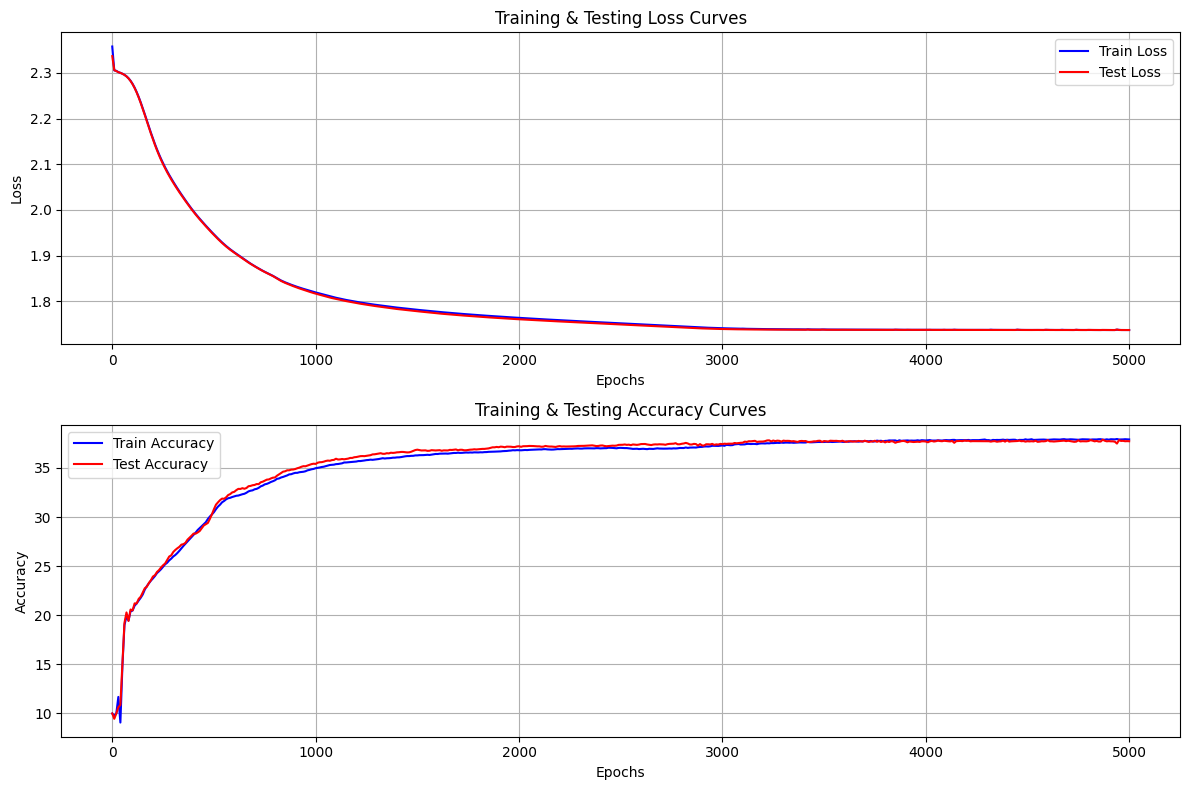

In [44]:
plot_loss_acc_curves(epoch_count, loss_values, test_loss_values, acc_values, test_acc_values)

Από τα παραπάνω αποτέλεσματα βλέπουμε πως μειώνοντας την διάσταση των δεδομένων καταφέραμε όντως να επιτύχουμε πολύ καλύτερο ποσοστό ακρίβειας στην ταξινόμηση των δεδομένων μας, γεγονός που μας επιβεβαιώνει πως το μεγαλύτερο πρόβλημα που αντιμετωπίζει το νευρωνικό μας στην κατηγοριοποίηση των δεδομένων στις κατάλληλες κλάσεις είναι το πρόβλημα των πολλών διαστάσεων που έχουν τα δείγματα. Αυτό μας δείχνει πως τα RBF δεν είναι κατάλληλα για την ταξινόμηση των εικόνων της CIFAR-10.

# **Σύγκριση με αλγορίθμους πλησιέστερου κέντρου και πλησιέστερου γείτονα**

In [52]:
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
# 1 Nearest Neighbour
knn_1 = KNeighborsClassifier(n_neighbors=1)
knn_1.fit(X_train, y_train)
y_preds = knn_1.predict(X_test)
acc_1 = accuracy_score(y_test, y_preds) * 100

# 3 Nearest Neighbours
knn_3 = KNeighborsClassifier(n_neighbors=3)
knn_3.fit(X_train, y_train)
y_preds = knn_3.predict(X_test)
acc_3 = accuracy_score(y_test, y_preds) * 100

# Nearest Centroid
nc = NearestCentroid()
nc.fit(X_train, y_train)
y_preds_nc = nc.predict(X_test)
acc_nc = accuracy_score(y_test, y_preds_nc) * 100

print(f"1 Nearest Neighbour Accuracy : {acc_1:.2f}% | 3 Nearest Neighbours Accuracy : {acc_3:.2f}% | Nearest Centroid Accuracy : {acc_nc:.2f}%")

1 Nearest Neighbour Accuracy : 35.39% | 3 Nearest Neighbours Accuracy : 33.03% | Nearest Centroid Accuracy : 27.74%


# **Τελικά συμπεράσματα για το RBF**


Όπως παρατηρούμε από τα παραπάνω το **RBF** νευρωνικό δίκτυο δεν είναι κατάλληλο για την κατηγοριοποίηση των δειγμάτων της CIFAR-10 καθότι έχει χειρότερη απόδοση από ότι οι αλγόριθμοι πλησιέστερου κέντρου και πλησιέστερου γείτονα. Το βασικό του θέμα είναι το πρόβλημα των πολλών διαστάσεων εξαιτίας του οποίου δεν μπορεί να εξάγει τα *καλά* χαρακτηριστικά του κάθε δείγματος και να πραγματοποιήσει σωστή κατηγοριοποίηση στις κατάλληλες κλάσεις. Ωστόσο, όπως είδαμε, και αυτό αποδίδει πολύ καλά όταν αντί για τα raw δεδομένα χρησιμοποιούνται τα HOG features ή μειώνεται η διάσταση με την χρήση **PCA** καθότι αυτό επιλύει σε κάποιο βαθμό το βασικό του πρόβλημα ενώ επίσης στις λιγότερες αυτές συνιστώσες κρατιέται και η πιο σημαντική πληροφορία του κάθε δείγματος με αποτέλεσμα να αποδίδει καλά και να ταξινομεί σωστά.

# **Autonencoder**

Οι **Autoencoders** είναι ένας τύπος τεχνητών νευρωνικών δικτύων που χρησιμοποιούνται για την εκμάθηση μιας συμπαγούς αναπαράστασης των δεδομένων (dimensionality reduction) ή για την απομάθηση θορύβου (denoising). Η βασική τους ιδέα είναι να μάθουν πώς να αναπαράγουν τα δεδομένα εισόδου μέσω ενός κρυφού επιπέδου που μειώνει τη διάσταση.

Αποτελούνται από δύο βασικά επίπεδα: 
* Encoder: Συμπιέζει τα δεδομένα εισόδου 
* Decoder: Ανακατασκευάζει τα δεδομένα από την αναπαράσταση στο κρυφό επίπεδο

Η έξοδος του δικτύου είναι μια προσέγγιση της εισόδου

Στόχος είναι η ελαχιστοποίηση της διαφοράς μεταξύ της εισόδου $x$ και της εξόδου $\hat x$ χρησιμοποιώντας την συνάρτηση κόστους $ L(x, \hat x) = \|x - \hat x\|^2$

Στην συνέχεια προσπαθώ να δημιουργήσω έναν autoencoder για την ανακατασκευή των ψηφίων της MNIST καθώς επίσης και την κατασκευή του επόμενου ψηφίου από αυτό που δίνεται στην είσοδο. Αρχικά κάνω εισαγωγή της MNIST βάσης δεδομένων χωρίζοντας τα σε training και σε validation set και στην συνέχεια κανονικοποιώντας και τα δύο σύνολα δεδομένων.

In [13]:
from torchvision import datasets, transforms

transforms = transforms.Compose([
    transforms.ToTensor(), # Convert the images to tensors
    transforms.Normalize((0.5,), (0.5, )) # Normalize the images with mean and std dev
])

train_data = datasets.MNIST(root='data', train=True, download=True, transform=transforms)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transforms)

In [7]:
train_dataset = TensorDataset((train_data.data / 255).to(device), train_data.targets.to(device))
test_dataset = TensorDataset((test_data.data / 255).to(device), test_data.targets.to(device))
train_data.data.shape, test_data.data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [8]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Στην συνέχεια υλοποιώ ένα πολύ απλό autoencoder με ένα μόνο ενδιάμεσο επίπεδο. Αυτός είναι ο πιο απλός autoencoder που μπορώ να φτιάξω. Ωστόσο, ένα πολύ πιθανό πρόβλημα είναι αυτός ο autoencoder μάλλον δεν θα μαθαίνει και δεν θα μπορεί να συγκεντρώσει την πιο σημαντική πληροφορία από τις εικόνες των ψηφίων της MNIST με αποτέλεσμα να μην έχουμε καλό reconstruction του ψηφίου στην έξοδο όπως και θα θέλαμε. Επίσης ένα ακόμα πιθανό πρόβλημα είναι ότι ο autoencoder αυτός δεν μαθαίνει αλλά κάνει απλά memorize την είσοδο χωρίς να χρειάζεται να συμπιέσει σημαντίκα features της κάθε εικόνας οπότε στην πραγματικότητα κάνει ένα ταυτοτικό mapping και άρα δεν έχει κάποια πρακτική αξία.

In [16]:
class Simple_Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Simple_Autoencoder, self).__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.decoder = nn.Linear(hidden_size, input_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.encoder(x)
        x = self.relu(x)
        x = self.decoder(x)
        x = self.sigmoid(x)
        return x

Υλοποιώ επίσης και κάποιες συναρτήσεις για την οπτικοποίηση των αποτελεσμάτων. Αρχικά φτιάχνω μια συνάρτηση στην οποία θα συγκρίνω τις εικόνες που δίνω ως είσοδο στο νευρωνικό δίκτυο με τις εικόνες που παράγει στην έξοδο ο autoencoder που έχω υλοποιήσει. Επίσης φτιάχνω και μια συνάρτηση για να σχεδιάσω την μείωση του training και του validation error ως συνάρτηση των epochs για τα οποία εκπαιδεύεται το νευρωνικό. 

In [18]:
def plot_reconstructed_images(autoencoder, test_loader, device, num_images=20):
    dataiter = iter(test_loader)  # Get a batch of test data
    images, labels = next(dataiter)  # Get the images and labels from the batch

    images = images.view(images.size(0), -1).to(device)  # Flatten images for the autoencoder

    with torch.inference_mode():
        reconstructed = autoencoder(images)  # Get the reconstructed images

    reconstructed = reconstructed.view(reconstructed.size(0), 28, 28).cpu()  # Move back to CPU for matplotlib

    # Plot original and reconstructed images
    plt.figure(figsize=(50, 4))
    for i in range(num_images):
        # Original images
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].cpu().numpy().reshape(28, 28), cmap='gray')  # Reshape the tensor to 28x28 and plot
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')

        # Reconstructed images
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructed[i].numpy(), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')
    plt.show()

def plot_loss_curves(epoch_count, train_losses, test_losses):
    plt.figure(figsize=(12, 8))
    plt.plot(epoch_count, train_losses, label='Train Loss', color='blue')
    plt.plot(epoch_count, test_losses, label='Test Loss', color='red')
    plt.title("Training & Testing Loss Curves")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [17]:
simple_auto = Simple_Autoencoder(784, 256).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(simple_auto.parameters(), lr=0.001)

epochs = 51
epoch_count = []
loss_values = []
test_loss_values = []

for epoch in range(epochs):
    train_loss = 0.0
    test_loss = 0.0

    simple_auto.train()
    for X, y in train_loader:
        X = X.view(X.size(0), -1)
        X = X.to(device)
        optimizer.zero_grad()
        output = simple_auto(X)
        loss = loss_fn(output, X)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    simple_auto.eval()
    for X, y in test_loader:
        X = X.view(X.size(0), -1)
        X = X.to(device)
        output = simple_auto(X)
        loss = loss_fn(output, X)
        test_loss += loss.item()
    
    test_loss /= len(test_loader)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(train_loss)
        test_loss_values.append(test_loss)
        print(f"Epoch {epoch} | Train Loss : {train_loss:.5f} | Test Loss : {test_loss:.5f}")

Epoch 0 | Train Loss : 0.02108 | Test Loss : 0.00621
Epoch 10 | Train Loss : 0.00111 | Test Loss : 0.00112
Epoch 20 | Train Loss : 0.00087 | Test Loss : 0.00091
Epoch 30 | Train Loss : 0.00079 | Test Loss : 0.00086
Epoch 40 | Train Loss : 0.00076 | Test Loss : 0.00082
Epoch 50 | Train Loss : 0.00074 | Test Loss : 0.00079


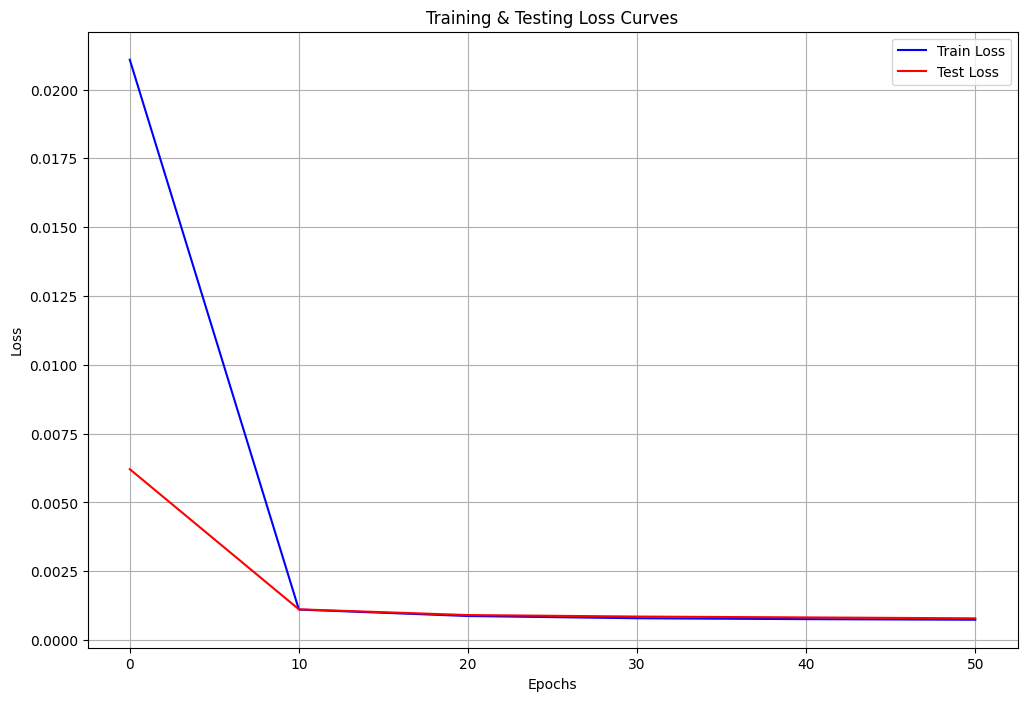

In [19]:
plot_loss_curves(epoch_count, loss_values, test_loss_values)

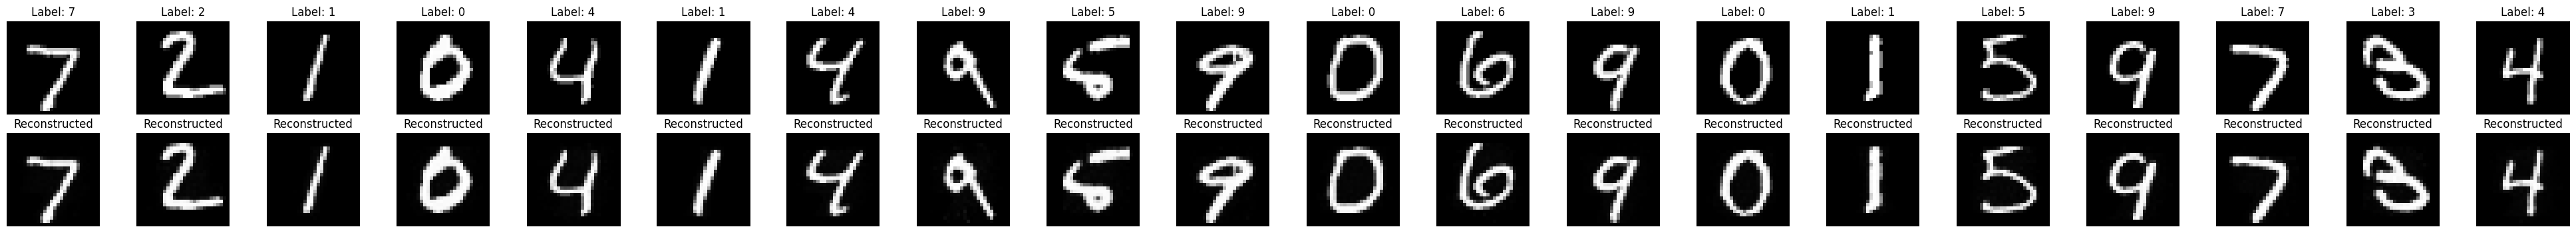

In [20]:
plot_reconstructed_images(simple_auto, test_loader, device, num_images=20)

Όπως βλέπουμε το loss μειώνεται ραγδαία κατά την διάρκεια εκπαίδευσης του autoencoder ενώ επίσης βλέπουμε ότι καταφέρνουμε να επιτύχουμε τέλεια ανακατασκευή των εικόνων στην έξοδο του autoencoder. Αυτό βεβαία μπορεί να σημαίνει δύο πράγματα. Είτε ότι ο autoencoder μας όντως μαθαίνει στο ενδιάμεσο επίπεδο τα ιδιαίτερα χαρακτηριστικά της κάθε εικόνας και είναι σε θέση να τα αναπαράγει στην έξοδο, είτε απλά αποστηθίζει την είσοδο χωρίς να μαθαίνει κάτι. Για να μπορέσουμε να επιβεβαιώσουμε ποιό από τα δύο ισχύει θα υλοποιήσουμε έναν αρκετά πιο σύνθετο autoencoder με περισσότερα κρυφά επίπεδα ο οποίος θα μπορεί σίγουρα να συλλάβει καλύτερα τα ιδιαίτερα χαρακτηριστικά των εικόνων στο latent space.

Παρακάτω φαίνεται η υλοποίηση του πιο σύνθετου autoencoder στον οποίο έχω βάλει περισσότερα κρυφά επίπεδα προκειμένου να μπορέσω να αναγκάσω το νευρωνικό να μαθαίνει τα ιδιαίτερα χαρακτηριστικά και όχι απλά να τα αποστηθίζει. Έχω βάλει επίσης στο κομμάτι του autoencoder και `Batch Normalization` το οποίο βοηθάει στο training stability ενώ επίσης επιταχγύνει και την ταχύτητα με την οποία ο autoencoder μαθαίνει και άρα συγκλίνει πιο γρήγορα στο αποτέλεσμα. Επίσης βοηθάει στην βελτιώση του represantation των χαρακτηριστικών της εικόνας στο latent space.

In [21]:
class MNIST_Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [22]:
mnist_auto = MNIST_Autoencoder().to(device) 

criterion = nn.MSELoss() # Mean Squared Error Loss

optimizer = torch.optim.Adam(mnist_auto.parameters(), lr=0.001)

epochs = 101
epoch_count = []
loss_values = []
test_loss_values = []

for epoch in range(epochs):

    train_loss = 0.0
    test_loss = 0.0

    for data in train_loader:
        mnist_auto.train()
        img, _ = data
        img = img.view(img.size(0), -1)
        output = mnist_auto(img)
        loss = criterion(output, img)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= len(train_loader)
    
    mnist_auto.eval()
    with torch.inference_mode():
        for data in test_loader:
            img, _ = data
            img = img.view(img.size(0), -1)
            output = mnist_auto(img)
            test_losses = criterion(output, img)
            test_loss += test_losses.item()
        
        test_loss /= len(test_loader)
    
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(train_loss)
        test_loss_values.append(test_loss)
        print(f'Epoch {epoch} |  Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} ')

Epoch 0 |  Loss: 0.0315 | Test Loss: 0.0197 
Epoch 10 |  Loss: 0.0091 | Test Loss: 0.0078 
Epoch 20 |  Loss: 0.0073 | Test Loss: 0.0064 
Epoch 30 |  Loss: 0.0062 | Test Loss: 0.0054 
Epoch 40 |  Loss: 0.0055 | Test Loss: 0.0046 
Epoch 50 |  Loss: 0.0049 | Test Loss: 0.0042 
Epoch 60 |  Loss: 0.0045 | Test Loss: 0.0039 
Epoch 70 |  Loss: 0.0042 | Test Loss: 0.0035 
Epoch 80 |  Loss: 0.0040 | Test Loss: 0.0034 
Epoch 90 |  Loss: 0.0038 | Test Loss: 0.0032 
Epoch 100 |  Loss: 0.0037 | Test Loss: 0.0030 


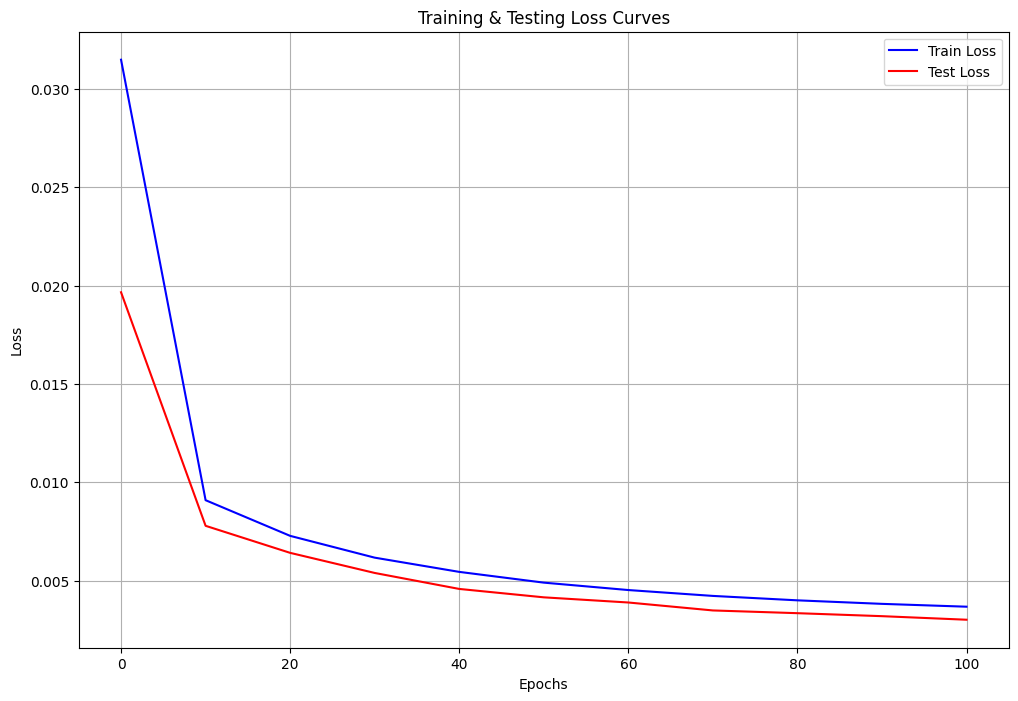

In [23]:
plot_loss_curves(epoch_count, loss_values, test_loss_values)

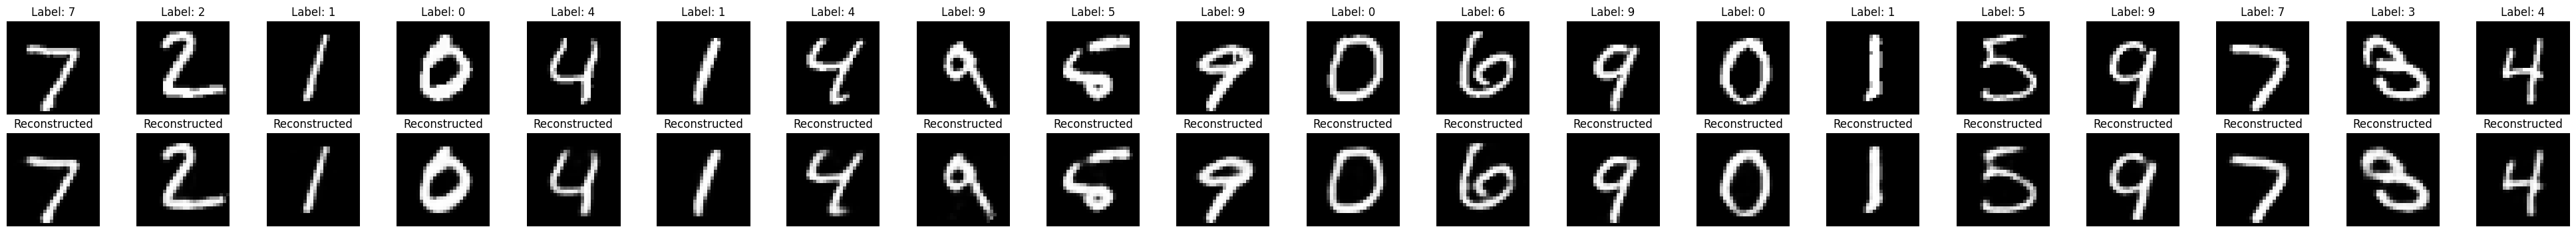

In [24]:
plot_reconstructed_images(mnist_auto, test_loader, device, num_images=20)

Από τα παραπάνω αποτελέσματα μπορούμε να δούμε πως τώρα έχουμε καταφέρει να μειώσουμε το loss και να ανακτήσουμε ξανά τις εικόνες που δίνουμε στην είσοδο. Επιπλέον βλέπουμε πως τώρα ο autoencoder μας όντως μαθαίνει τα ιδιαίτερα χαρακτηριστικά στο latent space και άρα μπορεί να σχηματίσει τις εικόνες στην έξοδο σε αντίθεση με προηγουμένως που απλά αποστήθιζε την είσοδο.

# **Ανακατασκευή Επόμενου Ψηφίου**

Στην συνέχεια θα επιδιώξω χρησιμοποιώντας τον autoencoder που υλοποιήσα προηγουμένως να φτιάχνω στην έξοδο το επόμενο ψηφίο από αυτό που μου δίνεται στην είσοδο. Για να το κάνω αυτό αρχικά φτιάχνω ένα dictionary στο οποίο βάζω όλες τις εικόνες ανάλογα με το label που έχουν. Στην συνέχεια αυτό που αλλάζει στο training loop είναι ότι παίρνω όλες τις εικόνες που αντιστοιχούν στο αμέσως επόμενο ψηφίο στο συγκεκριμένο batch και τις συγκρίνω με αυτό που παρήγαγε o autoencoder προσπαθώντας να μειώσω το loss και άρα να κατορθώσω να τις κάνω τελικά reconstruct στην έξοδο.

In [26]:
label_to_images = defaultdict(list)
for img, label in train_data:
    label_to_images[label].append(img) # Append the image to the list of images for the label

for label in label_to_images:
    label_to_images[label] = torch.stack(label_to_images[label]) # Convert the list of images to a tensor


autoencoder = MNIST_Autoencoder().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4)

epochs = 101

for epoch in range(epochs):
    autoencoder.train()
    running_loss = 0.0
    for x, y in train_loader:
        x = x.view(x.size(0), -1).to(device).float()
        y = y.to(device)

        # Get target images for (y + 1) % 10
        y_next = (y + 1) % 10
        target_images = []
        for label in y_next: # Get a random image from the next label
            target_img = label_to_images[label.item()] # Get all images for the label
            rand_idx = torch.randint(0, label_to_images[label.item()].size(0), (1,)) # Get a random index
            target_images.append(target_img[rand_idx]) # Get the image at the random index
        target_images = torch.cat(target_images).view(x.size(0), -1).to(device).float() # Concatenate and move to device

        outputs = autoencoder(x)
        loss = loss_fn(outputs, target_images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() 
    
    epoch_loss = running_loss / len(train_loader.dataset)

    autoencoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x = x.view(x.size(0), -1).to(device).float()
            y = y.to(device)

            # Get target images for (y + 1) % 10
            y_next = (y + 1) % 10
            target_images = []
            for label in y_next:
                target_img = label_to_images[label.item()]
                rand_idx = torch.randint(0, label_to_images[label.item()].size(0), (1,))
                target_images.append(target_img[rand_idx])
            target_images = torch.cat(target_images).view(x.size(0), -1).to(device).float()

            outputs = autoencoder(x)
            loss = loss_fn(outputs, target_images)
            val_loss += loss.item() * x.size(0)

        val_loss /= len(test_loader.dataset)
        
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Training Loss: {epoch_loss:.4f} | Validation Loss: {val_loss:.4f}")

Epoch 0 | Training Loss: 0.0157 | Validation Loss: 0.9245
Epoch 10 | Training Loss: 0.0144 | Validation Loss: 0.9201
Epoch 20 | Training Loss: 0.0144 | Validation Loss: 0.9193
Epoch 30 | Training Loss: 0.0144 | Validation Loss: 0.9190
Epoch 40 | Training Loss: 0.0144 | Validation Loss: 0.9192
Epoch 50 | Training Loss: 0.0144 | Validation Loss: 0.9191
Epoch 60 | Training Loss: 0.0144 | Validation Loss: 0.9189
Epoch 70 | Training Loss: 0.0144 | Validation Loss: 0.9187
Epoch 80 | Training Loss: 0.0144 | Validation Loss: 0.9188
Epoch 90 | Training Loss: 0.0144 | Validation Loss: 0.9189
Epoch 100 | Training Loss: 0.0144 | Validation Loss: 0.9181


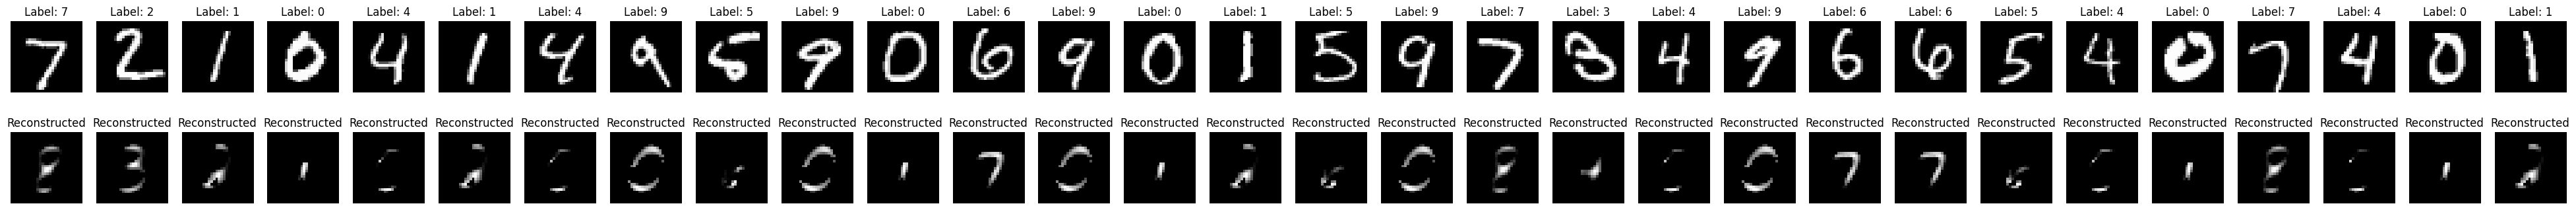

In [30]:
plot_reconstructed_images(autoencoder, test_loader, device, num_images=30)

Από τα παραπάνω βλέπουμε πως αν και δεν έχει καταφέρει να κάνει τέλεια αναπαράσταση των δειγμάτων στην έξοδο βλέπουμε ωστόσο πως το αποτέλεσμα είναι πολύ καλό θετικό καθότι μπορούμε αρκετά εύκολα να ξεχωρίσουμε και να διακρίνουμε το reconstructed ψηφίο. Ίσως με μια πιο κατάλληλη επιλογή των υπερπαραμέτρων να καταφέρναμε καλύτερα αποτελέσματα. Ας δοκιμάσουμε τώρα να υλοποιήσουμε έναν συνελικτικό autoencoder ο οποίος ελπίζουμε πως θα αποδόσει πολύ καλύτερα από τον προηγούμενο

# **Convolutional Autoencoder**

In [31]:
class Conv_Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), padding=0, stride=1), # 32x26x26
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=0, stride=1), # 64x24x24
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(64*24*24, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(128, 64*24*24),
            nn.LeakyReLU(),
            nn.Unflatten(1, (64, 24, 24)),
            nn.ConvTranspose2d(64, 32, kernel_size=(3, 3), padding=0, stride=1), # 32x26x26
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=(3, 3), padding=0, stride=1), # 1x28x28
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [35]:
label_to_images = defaultdict(list)
for img, label in train_data:
    label_to_images[label].append(img) # Append the image to the list of images for the label

for label in label_to_images:
    label_to_images[label] = torch.stack(label_to_images[label]) # Convert the list of images to a tensor


autoencoder = Conv_Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4)

epochs = 101

for epoch in range(epochs):
    autoencoder.train()
    running_loss = 0.0
    for x, y in train_loader:
        # x = x.view(x.size(0), -1).to(device).float()
        # y = y.to(device)
        x = x.unsqueeze(1).to(device).float()

        # Get target images for (y + 1) % 10
        y_next = (y + 1) % 10
        target_images = []
        for label in y_next: # Get a random image from the next label
            target_img = label_to_images[label.item()] # Get all images for the label
            rand_idx = torch.randint(0, label_to_images[label.item()].size(0), (1,)) # Get a random index
            target_images.append(target_img[rand_idx]) # Get the image at the random index
        target_images = torch.cat(target_images).to(device).float() # Concatenate and move to device
        # print(x.shape)

        outputs = autoencoder(x)
        loss = criterion(outputs, target_images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() 
    
    epoch_loss = running_loss / len(train_loader.dataset)
        
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Training Loss: {epoch_loss:.4f} ")

Epoch 0 | Training Loss: 0.0153 
Epoch 10 | Training Loss: 0.0143 
Epoch 20 | Training Loss: 0.0143 
Epoch 30 | Training Loss: 0.0143 
Epoch 40 | Training Loss: 0.0143 
Epoch 50 | Training Loss: 0.0143 
Epoch 60 | Training Loss: 0.0143 
Epoch 70 | Training Loss: 0.0143 
Epoch 80 | Training Loss: 0.0143 
Epoch 90 | Training Loss: 0.0143 
Epoch 100 | Training Loss: 0.0143 


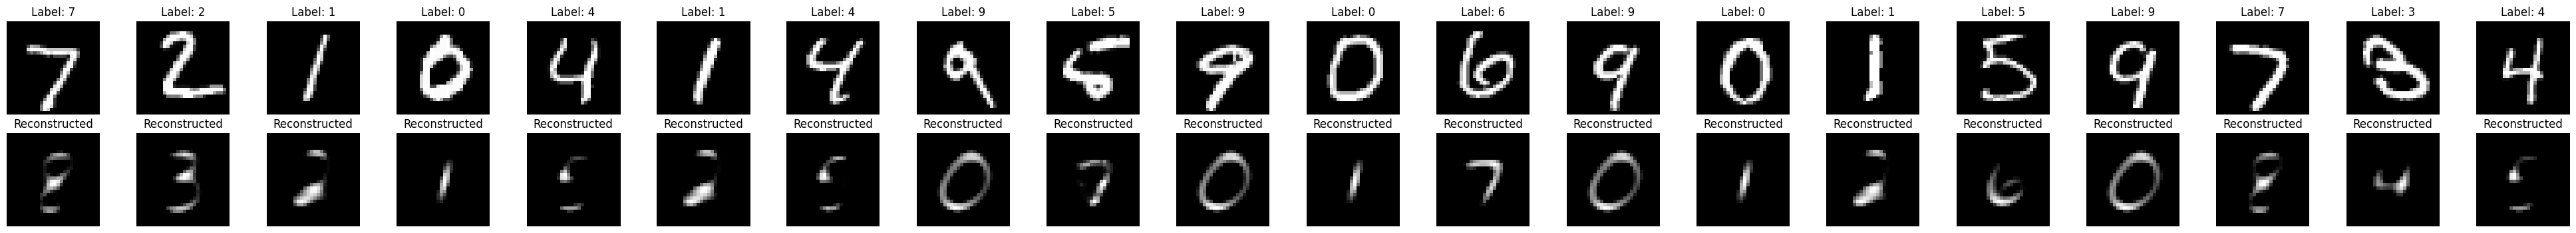

In [39]:
def plot_reconstructed_images(autoencoder, test_loader, device, num_images=20):
	dataiter = iter(test_loader)  # Get a batch of test data
	images, labels = next(dataiter)  # Get the images and labels from the batch

	images = images.view(images.size(0), 1, 28, 28).to(device)  # Reshape images for the autoencoder

	with torch.inference_mode():
		reconstructed = autoencoder(images)  # Get the reconstructed images

	reconstructed = reconstructed.view(reconstructed.size(0), 28, 28).cpu()  # Move back to CPU for matplotlib

	# Plot original and reconstructed images
	plt.figure(figsize=(50, 4))
	for i in range(num_images):
		# Original images
		ax = plt.subplot(2, num_images, i + 1)
		plt.imshow(images[i].cpu().numpy().reshape(28, 28), cmap='gray')  # Reshape the tensor to 28x28 and plot
		plt.title(f"Label: {labels[i].item()}")
		plt.axis('off')

		# Reconstructed images
		ax = plt.subplot(2, num_images, i + 1 + num_images)
		plt.imshow(reconstructed[i].numpy(), cmap='gray')
		plt.title("Reconstructed")
		plt.axis('off')
	plt.show()

plot_reconstructed_images(autoencoder, test_loader, device, num_images=20)

Όπως βλέπουμε τώρα τα αποτελέσματα που παίρνουμε είναι πολύ καλύτερα από προηγουμένως κάτι που περιμέναμε καθότι ο συνελικτικός autoencoder αποδίδει πολύ καλύτερα αφού χρησιμοποιεί συνελικτικά φίλτρα για να λάβει καλύτερα την πληροφορία από τις εικόνες και άρα μπορεί να δημιουργήσει πιο ορθά το επόμενο ψηφίο από αυτό που του δίνεται στην είσοδο. Στην συνέχεια για να μπορέσουμε να αξιολογήσουμε πόσο καλά είναι τα ψηφία που έχουν γίνει reconstruct από τον συνελικτικό δίκτυο θα χρησιμοποιήσω ένα συνελικτικό νευρωνικό δίκτυο καθώς και ένα MLP για να δούμε σε τι ποσοστό αναγνωρίζει τα ψηφία.

In [40]:
class ConvolutionMNIST(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3, 3), padding=1), # 16x28x28  
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=(3, 3), padding=1), # 16x28x28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)) # 16x14x14
        )

        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(3, 3), padding=1), # 32x14x14
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1), # 32x14x14
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)) # 32x7x7
        )

        self.linear_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=32 * 7 * 7, out_features=128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(in_features=128, out_features=10)
        )

    def forward(self, x):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.linear_layer(x)
        return x

In [41]:
class MLP_MNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=28*28, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=10)
        )

    def forward(self, x):
        x = self.linear_layer(x)
        return x

Στο παρακάτω κελί φτιάχνω το σετ που θα χρησιμοποιήσω για την αξιολόγηση του reconstruction. Αρχικά μετατρέπως όλες τις εικόνες του training σετ καθώς και του validation σετ και στην συνέχεια τους δίνω το κατάλληλο label το οποίο είναι το επόμενο νούμερο από αυτό που είχαν όταν μπήκαν στην είσοδο του autoencoder.

In [42]:
reconstructed_images_train = []
y_train_labels = []
reconstructed_images_test = []
y_test_labels = []
autoencoder.eval()
with torch.inference_mode():
    for x, y in train_loader:
        x = x.unsqueeze(1).to(device).float()
        y_train_labels.append(y.cpu().detach())
        outputs = autoencoder(x)
        reconstructed_images_train.append(outputs.cpu().detach())

    for x, y in test_loader:
        x = x.unsqueeze(1).to(device).float()
        y_test_labels.append(y.cpu().detach())
        outputs = autoencoder(x)
        reconstructed_images_test.append(outputs.cpu().detach())

reconstructed_images = torch.cat(reconstructed_images_train, dim=0).to(device)
y_train_labels = torch.cat(y_train_labels, dim=0).to(device)
reconstructed_images_test = torch.cat(reconstructed_images_test, dim=0).to(device)
y_test_labels = torch.cat(y_test_labels, dim=0).to(device)

In [43]:
y_train_labels = ( y_train_labels + 1 ) % 10 # Get the correct label for the next digit
y_test_labels  = ( y_test_labels + 1 ) % 10  # Get the correct label for the next digit

In [44]:
reconstructed_trainloader = DataLoader(TensorDataset(reconstructed_images, y_train_labels), batch_size=64, shuffle=True)
reconstructed_testloader = DataLoader(TensorDataset(reconstructed_images_test, y_test_labels), batch_size=64, shuffle=False)

In [47]:
conv_model = ConvolutionMNIST().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(conv_model.parameters(), lr=1e-4)

epochs = 101
epoch_count = []
loss_values = []
test_loss_values = []
acc_values = []
test_acc_values = []

for epoch in range(epochs):
    train_loss = 0.0
    test_loss = 0.0
    train_acc = 0.0
    test_acc = 0.0

    for X, y in reconstructed_trainloader:
        conv_model.train()

        y_logits = conv_model(X)
        y_pred_probs = torch.softmax(y_logits, dim=1)
        y_preds = torch.argmax(y_pred_probs, dim=1)

        loss = loss_fn(y_logits, y)
        acc = accuracy(y, y_preds)

        train_loss += loss.item()
        train_acc += acc

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss /= len(reconstructed_trainloader)
    train_acc /= len(reconstructed_trainloader)

    conv_model.eval()
    with torch.inference_mode():
        for X, y in reconstructed_testloader:
            y_logits = conv_model(X)
            y_pred_probs = torch.softmax(y_logits, dim=1)
            y_preds = torch.argmax(y_pred_probs, dim=1)

            loss = loss_fn(y_logits, y)
            acc = accuracy(y, y_preds)

            test_loss += loss.item()
            test_acc += acc

    test_loss /= len(reconstructed_testloader)
    test_acc /= len(reconstructed_testloader)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(train_loss)
        test_loss_values.append(test_loss)
        acc_values.append(train_acc)
        test_acc_values.append(test_acc)
        print(f"Epoch {epoch} | Loss : {train_loss:.5f} | Accuracy : {train_acc:.2f}% | Test Loss : {test_loss:.5f} | Test Accuracy : {test_acc:.2f}%")

Epoch 0 | Loss : 0.48154 | Accuracy : 84.46% | Test Loss : 0.10635 | Test Accuracy : 98.67%
Epoch 10 | Loss : 0.00207 | Accuracy : 99.97% | Test Loss : 0.11234 | Test Accuracy : 98.90%
Epoch 20 | Loss : 0.00163 | Accuracy : 99.98% | Test Loss : 0.12271 | Test Accuracy : 98.94%
Epoch 30 | Loss : 0.00150 | Accuracy : 99.98% | Test Loss : 0.13013 | Test Accuracy : 98.92%
Epoch 40 | Loss : 0.00131 | Accuracy : 99.98% | Test Loss : 0.11886 | Test Accuracy : 98.85%
Epoch 50 | Loss : 0.00127 | Accuracy : 99.99% | Test Loss : 0.12431 | Test Accuracy : 98.84%
Epoch 60 | Loss : 0.00117 | Accuracy : 99.99% | Test Loss : 0.12812 | Test Accuracy : 98.88%
Epoch 70 | Loss : 0.00135 | Accuracy : 99.99% | Test Loss : 0.13478 | Test Accuracy : 98.87%
Epoch 80 | Loss : 0.00101 | Accuracy : 99.99% | Test Loss : 0.14559 | Test Accuracy : 98.92%
Epoch 90 | Loss : 0.00108 | Accuracy : 99.99% | Test Loss : 0.13948 | Test Accuracy : 98.87%
Epoch 100 | Loss : 0.00111 | Accuracy : 99.99% | Test Loss : 0.11529 | 

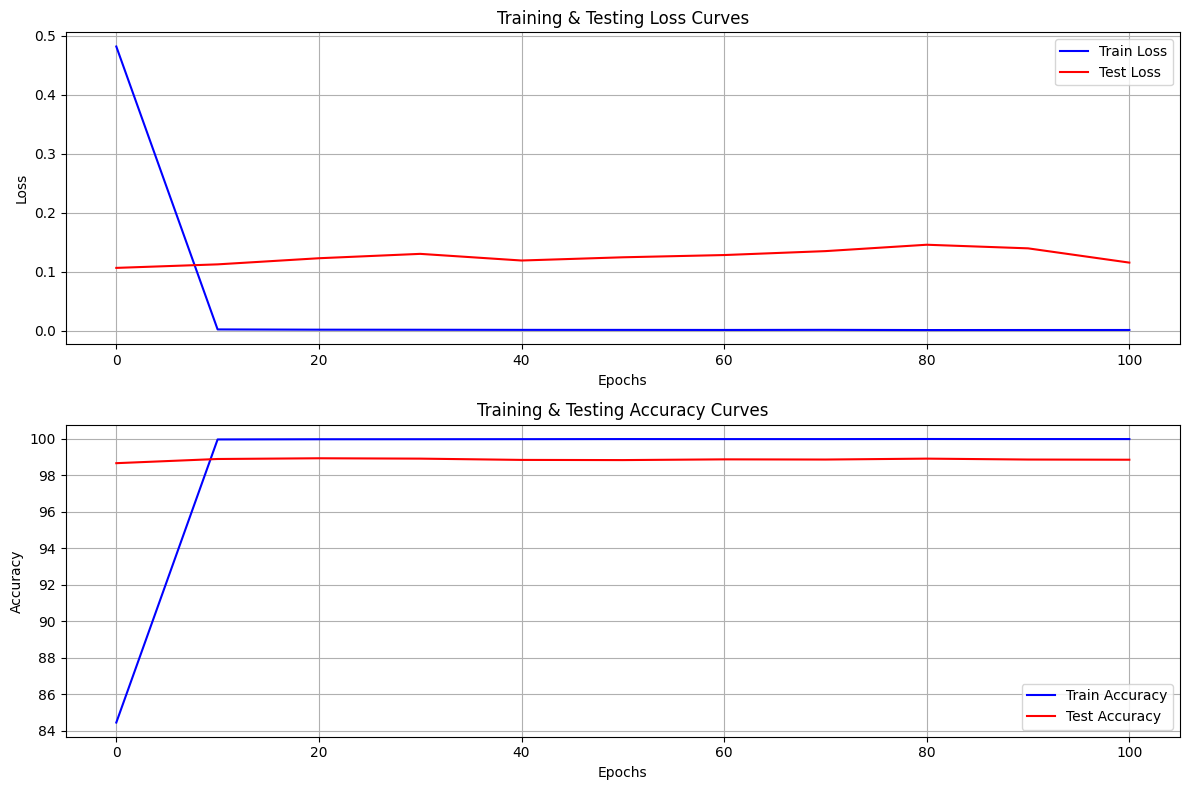

In [48]:
plot_loss_acc_curves(epoch_count, loss_values, test_loss_values, acc_values, test_acc_values)

Από τα παραπάνω βλέπουμε αρκετά θετικά αποτελέσματα, γεγονός που μας δείχνει πως το συνελικτικό δίκτυο είναι σε θέση να αναγνωρίσει με μεγάλη επιτυχία τα ψηφία τα οποία φτιάχνει στην έξοδο του ο autoencoder. Ας δοκιμάσουμε τώρα να δούμε και πως θα τα καταφέρει και ο MLP να αναγνωρίσει τα ψηφία που έχουμε φτιάξει με τον autoencoder.

In [49]:
mlp_mnist = MLP_MNIST().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_mnist.parameters(), lr=1e-4)

epochs = 101
epoch_count = []
loss_values = []
test_loss_values = []
acc_values = []
test_acc_values = []

for epoch in range(epochs):
    train_loss = 0.0
    test_loss = 0.0
    train_acc = 0.0
    test_acc = 0.0

    for X, y in reconstructed_trainloader:
        mlp_mnist.train()

        y_logits = mlp_mnist(X.view(X.size(0), -1))
        y_pred_probs = torch.softmax(y_logits, dim=1)
        y_preds = torch.argmax(y_pred_probs, dim=1)

        loss = loss_fn(y_logits, y)
        acc = accuracy(y, y_preds)

        train_loss += loss.item()
        train_acc += acc

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss /= len(reconstructed_trainloader)
    train_acc /= len(reconstructed_trainloader)

    mlp_mnist.eval()
    with torch.inference_mode():
        for X, y in reconstructed_testloader:
            y_logits = mlp_mnist(X.view(X.size(0), -1))
            y_pred_probs = torch.softmax(y_logits, dim=1)
            y_preds = torch.argmax(y_pred_probs, dim=1)

            loss = loss_fn(y_logits, y)
            acc = accuracy(y, y_preds)


            test_acc += acc
            test_loss += loss.item()

    test_loss /= len(reconstructed_testloader)
    test_acc /= len(reconstructed_testloader)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(train_loss)
        test_loss_values.append(test_loss)
        acc_values.append(train_acc)
        test_acc_values.append(test_acc)
        print(f"Epoch {epoch} | Loss : {train_loss:.5f} | Accuracy : {train_acc:.2f}% | Test Loss : {test_loss:.5f} | Test Accuracy : {test_acc:.2f}%")

Epoch 0 | Loss : 0.73661 | Accuracy : 91.50% | Test Loss : 0.07059 | Test Accuracy : 98.85%
Epoch 10 | Loss : 0.00137 | Accuracy : 99.98% | Test Loss : 0.07553 | Test Accuracy : 98.96%
Epoch 20 | Loss : 0.00116 | Accuracy : 99.98% | Test Loss : 0.08827 | Test Accuracy : 98.96%
Epoch 30 | Loss : 0.00102 | Accuracy : 99.98% | Test Loss : 0.09566 | Test Accuracy : 98.98%
Epoch 40 | Loss : 0.00095 | Accuracy : 99.99% | Test Loss : 0.10339 | Test Accuracy : 98.97%
Epoch 50 | Loss : 0.00090 | Accuracy : 99.99% | Test Loss : 0.10979 | Test Accuracy : 98.97%
Epoch 60 | Loss : 0.00085 | Accuracy : 99.99% | Test Loss : 0.11664 | Test Accuracy : 98.97%
Epoch 70 | Loss : 0.00083 | Accuracy : 99.99% | Test Loss : 0.12509 | Test Accuracy : 98.98%
Epoch 80 | Loss : 0.00078 | Accuracy : 99.99% | Test Loss : 0.13325 | Test Accuracy : 98.96%
Epoch 90 | Loss : 0.00075 | Accuracy : 99.99% | Test Loss : 0.14247 | Test Accuracy : 98.95%
Epoch 100 | Loss : 0.00069 | Accuracy : 99.99% | Test Loss : 0.14976 | 

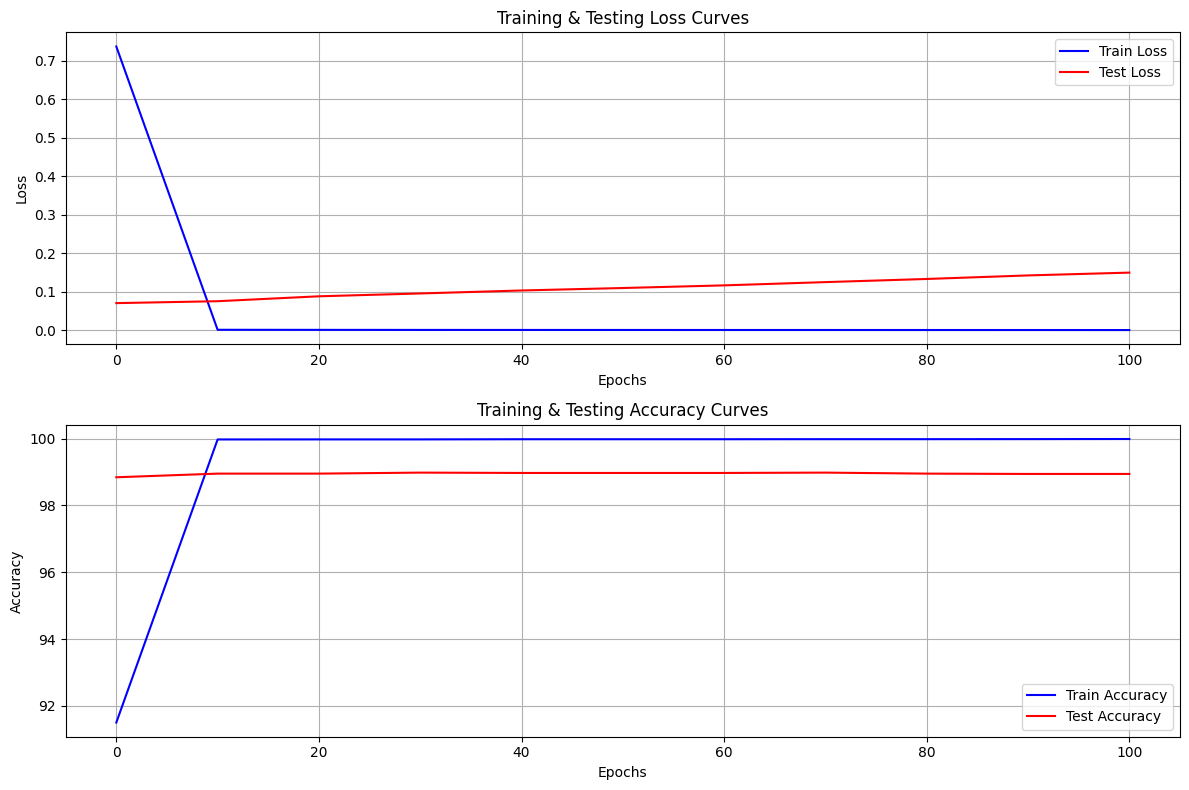

In [50]:
plot_loss_acc_curves(epoch_count, loss_values, test_loss_values, acc_values, test_acc_values)

Όπως μπορούμε να παρατηρήσουμε και ο MLP αποδίδει εξαιρετικά καλά και είναι σε θέση να αναγνωρίσει τα ψηφία που έχουν κατασκευαστεί από τον συνελικτικό autoencoder.